In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [2]:
df = pd.read_csv("dataset.csv",delimiter=";")
df['tanggal'] = pd.to_datetime(df['tanggal'])
df.head()

,tanggal,wilayah,waktu,cuaca,kelembaban_persen,suhu_derajat_celcius
0,2017-01-03,Jakarta Barat,Malam,Hujan Ringan,65 - 95,22 - 31
1,2017-01-03,Jakarta Barat,Pagi,Hujan Ringan,65 - 95,22 - 31
2,2017-01-03,Jakarta Barat,Siang,Hujan Petir,65 - 95,22 - 31
3,2017-01-03,Jakarta Pusat,Malam,Hujan Ringan,65 - 95,22 - 31
4,2017-01-03,Jakarta Pusat,Pagi,Hujan Ringan,65 - 95,22 - 31


# Data Cleaning

In [3]:
print("Data terdiri dari", df.shape[0], "baris")
print("Data terdiri dari", df.shape[1], "\tkolom")

Data terdiri dari 14676 baris
Data terdiri dari 6 	kolom


In [4]:
print("Missing Value")
print(df.isnull().sum())

print("\nData Duplicate")
print(df.duplicated().sum())

Missing Value
tanggal                 0
wilayah                 0
waktu                   0
cuaca                   0
kelembaban_persen       0
suhu_derajat_celcius    0
dtype: int64

Data Duplicate
0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14676 entries, 0 to 14675
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   tanggal               14676 non-null  datetime64[ns]
 1   wilayah               14676 non-null  object        
 2   waktu                 14676 non-null  object        
 3   cuaca                 14676 non-null  object        
 4   kelembaban_persen     14676 non-null  object        
 5   suhu_derajat_celcius  14676 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 688.1+ KB


In [6]:
categoric = ['wilayah', 'waktu', 'cuaca']
df[categoric].describe()

,wilayah,waktu,cuaca
count,14676,14676,14676
unique,6,8,33
top,Jakarta Barat,Malam,Cerah Berawan
freq,2446,3354,5111


In [7]:
print("Date Minimum", df["tanggal"].min(), "\tDate Maximum", df["tanggal"].max())

Date Minimum 2017-01-03 00:00:00 	Date Maximum 2018-12-31 00:00:00


# Preprocessing

## Proses Kolom Tanggal

In [8]:
parse_date = df['tanggal'].dt

df["hari"] = parse_date.day
df['bulan'] = parse_date.month
df['tahun'] = parse_date.year

df.head()

,tanggal,wilayah,waktu,cuaca,kelembaban_persen,suhu_derajat_celcius,hari,bulan,tahun
0,2017-01-03,Jakarta Barat,Malam,Hujan Ringan,65 - 95,22 - 31,3,1,2017
1,2017-01-03,Jakarta Barat,Pagi,Hujan Ringan,65 - 95,22 - 31,3,1,2017
2,2017-01-03,Jakarta Barat,Siang,Hujan Petir,65 - 95,22 - 31,3,1,2017
3,2017-01-03,Jakarta Pusat,Malam,Hujan Ringan,65 - 95,22 - 31,3,1,2017
4,2017-01-03,Jakarta Pusat,Pagi,Hujan Ringan,65 - 95,22 - 31,3,1,2017


## Proses Kolom Cuaca

In [9]:
print(df['cuaca'].value_counts(), "\n")
print("Panjang Data", len(df['cuaca'].value_counts()), "Jenis")

Cerah Berawan     5111
Berawan           4037
Hujan Lokal       1916
Hujan Ringan      1177
Berawan Tebal      893
Cerah              610
Hujan Sedang       423
Hujan Petir        347
Cerah Berawan       61
Cerah               26
Berawan             22
Hujan Lokal         13
Udara Kabur          9
Hujan Ringan         4
Hujan                3
 Berawan             3
Berawan Tebal        3
Cerah Berawah        2
Cerah berawan        2
Hujan RIngan         1
Berawan Teba         1
Hujan Loka           1
Hujang Sedang        1
Berawan Sedang       1
Berawa               1
Hujan Ringanl        1
Hujan Sedang         1
Hujan Petir          1
Cerah                1
Berawan tebal        1
Beawan               1
Cerang Berawan       1
Cerah Berawn         1
Name: cuaca, dtype: int64 

Panjang Data 33 Jenis


In [10]:
import re

def cuaca(x):
  if (re.findall("Cerah", x)):
    return 'Cerah'
  elif (re.findall("Hujan", x)):
    return 'Hujan'
  elif (re.findall("Berawan", x)):
    return 'Berawan'
  else:
    return 'Tidak Teridentifikasi'

df["cuaca"] = df['cuaca'].apply(cuaca)
df["cuaca"].value_counts()

Cerah                    5814
Berawan                  4962
Hujan                    3889
Tidak Teridentifikasi      11
Name: cuaca, dtype: int64

In [11]:
df.drop(df[df["cuaca"] == "Tidak Teridentifikasi"].index, inplace=True)
df["cuaca"].unique()

array(['Hujan', 'Berawan', 'Cerah'], dtype=object)

## Proses Kolom Waktu

In [12]:
print(df['waktu'].value_counts(), "\n")
print("Panjang Data", len(df['waktu'].value_counts()), "Jenis")

Pagi         3354
Siang        3354
Malam        3348
Dini Hari    3242
malam         342
pagi          342
siang         342
dini hari     341
Name: waktu, dtype: int64 

Panjang Data 8 Jenis


In [13]:
import re

def cuaca(x):
  if (re.findall("dini hari", x)):
    return 'Dini Hari'
  elif (re.findall("siang", x)):
    return 'Siang'
  elif (re.findall("pagi", x)):
    return 'Pagi'
  elif (re.findall("malam", x)):
    return 'Malam'
  else:
    return x

df["waktu"] = df['waktu'].apply(cuaca)
df["waktu"].value_counts()

Pagi         3696
Siang        3696
Malam        3690
Dini Hari    3583
Name: waktu, dtype: int64

## Proses Kolom Kelembaban

In [14]:
df["kelembaban_min"] = df['kelembaban_persen'].apply(lambda x: x.split("-")[0])
df["kelembaban_min"] = [x.strip(' ') for x in df["kelembaban_min"]]

df["kelembaban_max"] = df['kelembaban_persen'].apply(lambda x: x.split("-")[1])
df["kelembaban_max"] = [x.strip(' ') for x in df["kelembaban_max"]]

df['kelembaban_mean'] = (df['kelembaban_min'].astype(int) + df['kelembaban_max'].astype(int)) / 2
df.drop(columns=['kelembaban_persen'], inplace=True)

df.head()

,tanggal,wilayah,waktu,cuaca,suhu_derajat_celcius,hari,bulan,tahun,kelembaban_min,kelembaban_max,kelembaban_mean
0,2017-01-03,Jakarta Barat,Malam,Hujan,22 - 31,3,1,2017,65,95,80.0
1,2017-01-03,Jakarta Barat,Pagi,Hujan,22 - 31,3,1,2017,65,95,80.0
2,2017-01-03,Jakarta Barat,Siang,Hujan,22 - 31,3,1,2017,65,95,80.0
3,2017-01-03,Jakarta Pusat,Malam,Hujan,22 - 31,3,1,2017,65,95,80.0
4,2017-01-03,Jakarta Pusat,Pagi,Hujan,22 - 31,3,1,2017,65,95,80.0


## Proses Kolom Suhu

In [15]:
df["suhu_min"] = df.suhu_derajat_celcius.apply(lambda x: x.split("-")[0])
df["suhu_min"] = [x.strip(' ') for x in df["suhu_min"]]

df["suhu_max"] = df.suhu_derajat_celcius.apply(lambda x: x.split("-")[1])
df["suhu_max"] = [x.strip(' ') for x in df["suhu_max"]]

df['suhu_mean'] = (df['suhu_min'].astype(int) + df['suhu_max'].astype(int)) / 2
df.drop(columns=['suhu_derajat_celcius'], inplace=True)

df.head()

,tanggal,wilayah,waktu,cuaca,hari,bulan,tahun,kelembaban_min,kelembaban_max,kelembaban_mean,suhu_min,suhu_max,suhu_mean
0,2017-01-03,Jakarta Barat,Malam,Hujan,3,1,2017,65,95,80.0,22,31,26.5
1,2017-01-03,Jakarta Barat,Pagi,Hujan,3,1,2017,65,95,80.0,22,31,26.5
2,2017-01-03,Jakarta Barat,Siang,Hujan,3,1,2017,65,95,80.0,22,31,26.5
3,2017-01-03,Jakarta Pusat,Malam,Hujan,3,1,2017,65,95,80.0,22,31,26.5
4,2017-01-03,Jakarta Pusat,Pagi,Hujan,3,1,2017,65,95,80.0,22,31,26.5


## Mengubah Tipe Data

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14665 entries, 0 to 14675
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   tanggal          14665 non-null  datetime64[ns]
 1   wilayah          14665 non-null  object        
 2   waktu            14665 non-null  object        
 3   cuaca            14665 non-null  object        
 4   hari             14665 non-null  int64         
 5   bulan            14665 non-null  int64         
 6   tahun            14665 non-null  int64         
 7   kelembaban_min   14665 non-null  object        
 8   kelembaban_max   14665 non-null  object        
 9   kelembaban_mean  14665 non-null  float64       
 10  suhu_min         14665 non-null  object        
 11  suhu_max         14665 non-null  object        
 12  suhu_mean        14665 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(7)
memory usage: 1.6+ MB


In [17]:
df["kelembaban_min"] = df.kelembaban_min.astype(float)
df["kelembaban_max"] = df.kelembaban_max.astype(float)
df["suhu_min"] = df.suhu_min.astype(float)
df["suhu_max"] = df.suhu_max.astype(float)
df.dtypes

tanggal            datetime64[ns]
wilayah                    object
waktu                      object
cuaca                      object
hari                        int64
bulan                       int64
tahun                       int64
kelembaban_min            float64
kelembaban_max            float64
kelembaban_mean           float64
suhu_min                  float64
suhu_max                  float64
suhu_mean                 float64
dtype: object

## Statistik Data

In [18]:
categoric = ['wilayah', 'waktu', 'cuaca']
numeric = ['kelembaban_min', 'kelembaban_max', 'kelembaban_mean', 'suhu_min', 'suhu_max', 'suhu_mean']

In [19]:
df[categoric].describe()

,wilayah,waktu,cuaca
count,14665,14665,14665
unique,6,4,3
top,Jakarta Pusat,Pagi,Cerah
freq,2445,3696,5814


In [20]:
df[numeric].describe()

,kelembaban_min,kelembaban_max,kelembaban_mean,suhu_min,suhu_max,suhu_mean
count,14665.000000,14665.000000,14665.000000,14665.000000,14665.000000,14665.000000
mean,63.315377,91.454756,77.385066,23.778248,32.493420,28.135834
std,10.197204,5.672470,7.213556,0.908185,1.156165,0.745253
min,35.000000,70.000000,55.000000,20.000000,28.000000,25.500000
25%,55.000000,90.000000,72.500000,23.000000,32.000000,27.500000
50%,65.000000,95.000000,77.500000,24.000000,33.000000,28.000000
75%,70.000000,95.000000,82.500000,24.000000,33.000000,28.500000
max,95.000000,100.000000,95.000000,27.000000,35.000000,30.000000


## Korelasi

In [21]:
df.corr()

,hari,bulan,tahun,kelembaban_min,kelembaban_max,kelembaban_mean,suhu_min,suhu_max,suhu_mean
hari,1.000000,0.017493,0.023448,0.063404,0.021476,0.053259,0.042097,-0.007332,0.019963
bulan,0.017493,1.000000,0.121595,-0.356805,-0.348540,-0.389232,0.196264,0.402895,0.432106
tahun,0.023448,0.121595,1.000000,-0.120413,0.055721,-0.063200,-0.292899,0.115324,-0.089012
kelembaban_min,0.063404,-0.356805,-0.120413,1.000000,0.622213,0.951451,0.045814,-0.545484,-0.395209
kelembaban_max,0.021476,-0.348540,0.055721,0.622213,1.000000,0.832966,-0.056909,-0.341720,-0.299743
kelembaban_mean,0.053259,-0.389232,-0.063200,0.951451,0.832966,1.000000,0.010006,-0.519911,-0.397191
suhu_min,0.042097,0.196264,-0.292899,0.045814,-0.056909,0.010006,1.000000,0.028615,0.631509
suhu_max,-0.007332,0.402895,0.115324,-0.545484,-0.341720,-0.519911,0.028615,1.000000,0.793122
suhu_mean,0.019963,0.432106,-0.089012,-0.395209,-0.299743,-0.397191,0.631509,0.793122,1.000000


# Visualisasi

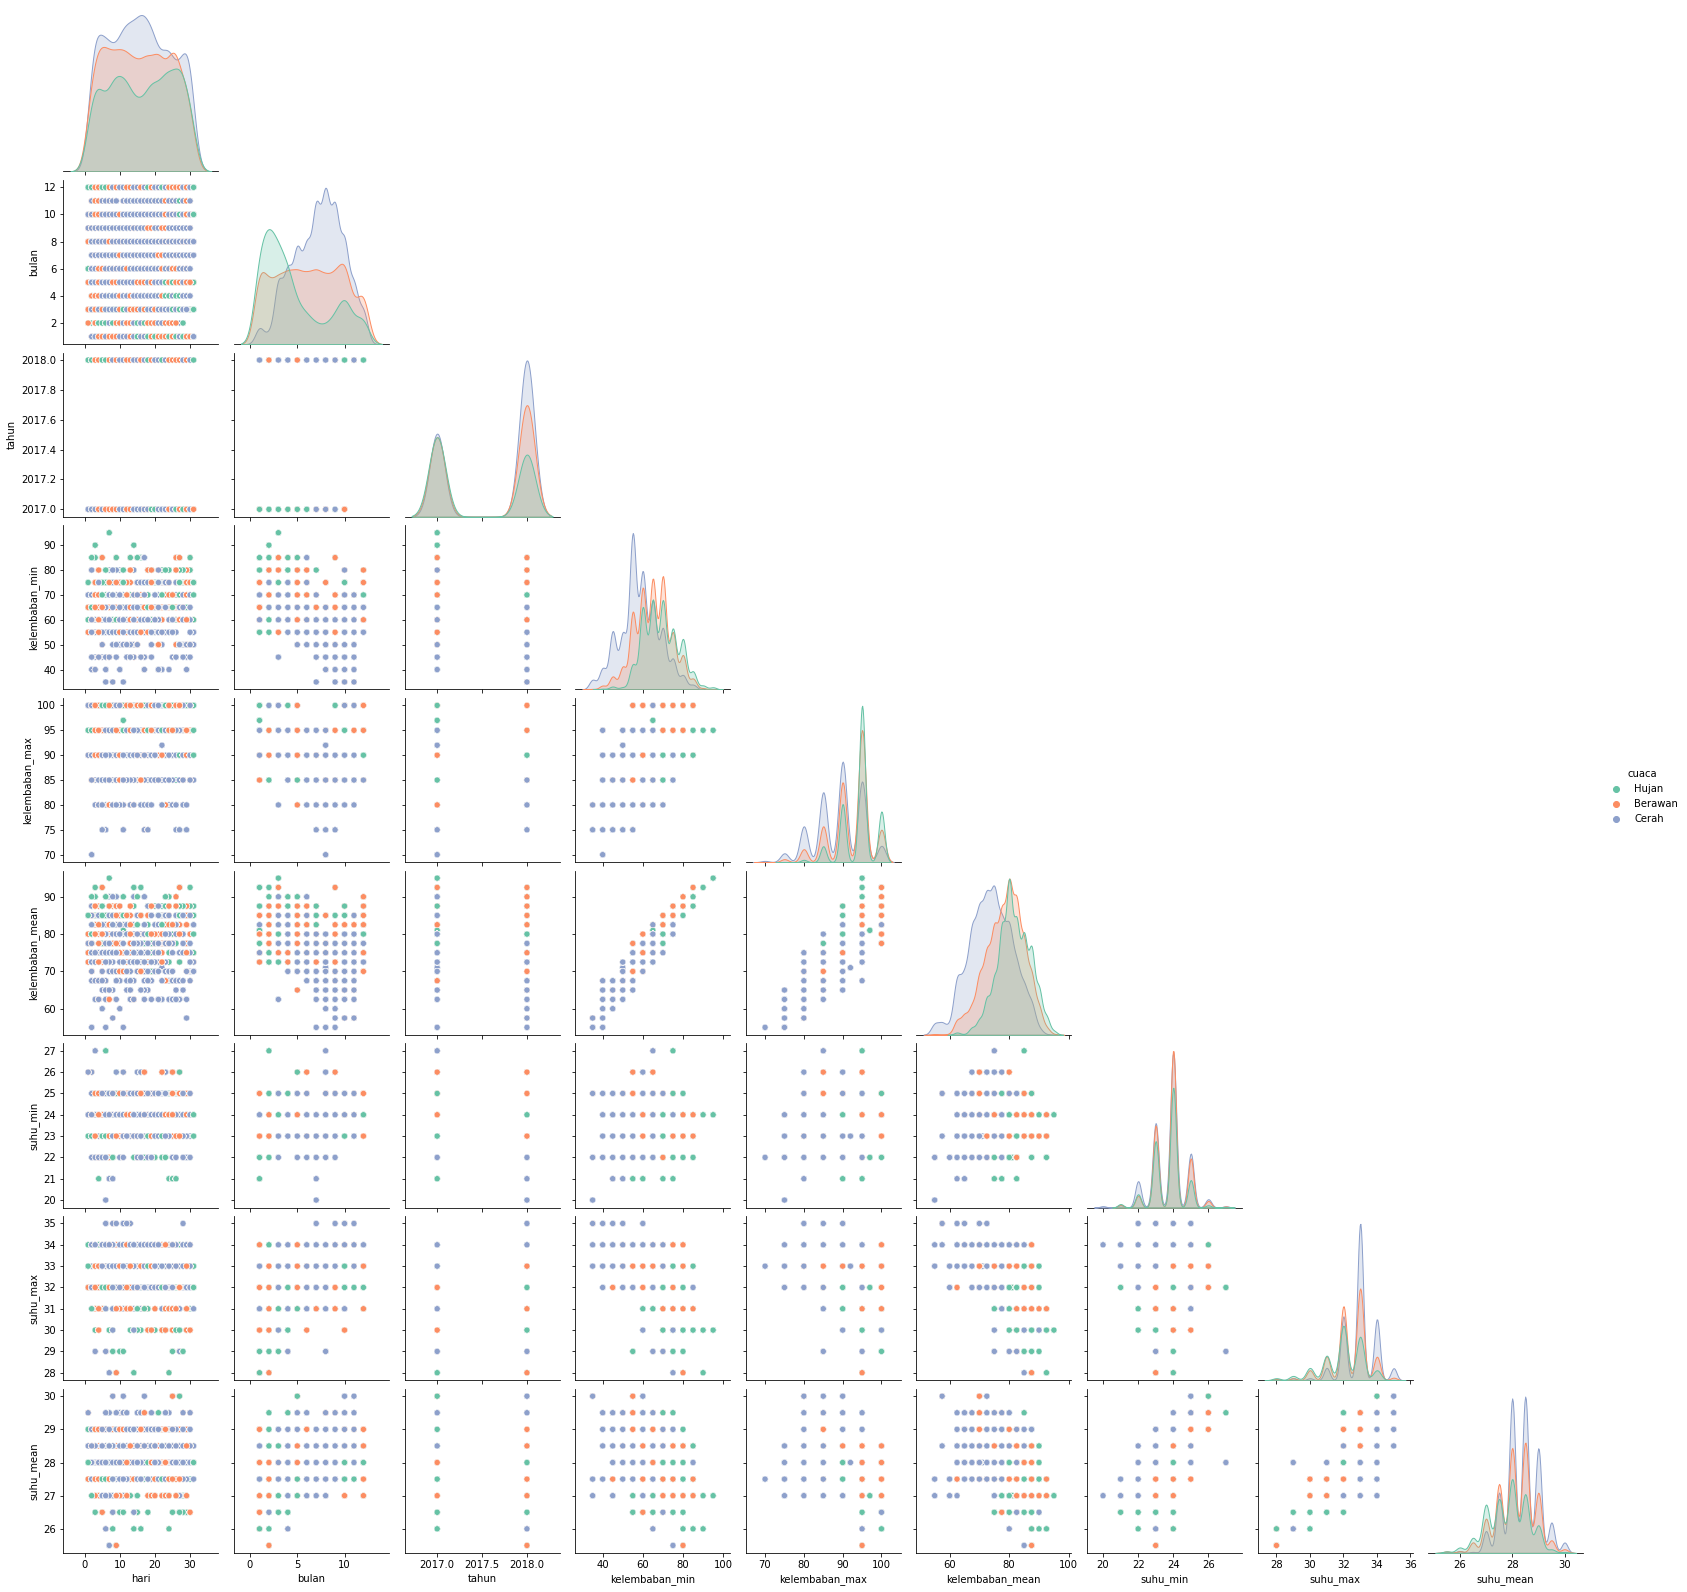

In [22]:
sns.pairplot(df, hue="cuaca", corner=True, diag_kind="auto", palette="Set2")

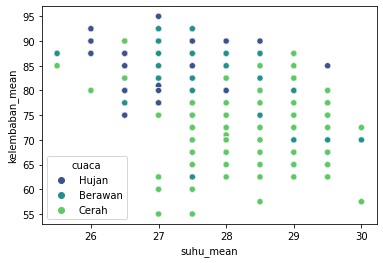

In [23]:
plot = df.copy()
plot = plot.set_index('tanggal')
sns.scatterplot(data=plot, x="suhu_mean", y="kelembaban_mean", palette="viridis", hue="cuaca");

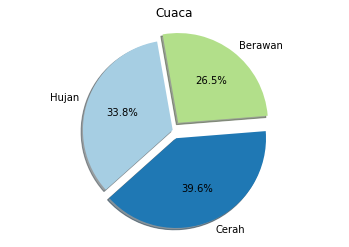

In [24]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['Hujan', 'Cerah', 'Berawan']
explode = (0, 0.1, 0.1)

#define Seaborn color palette to use
colors = sns.color_palette('Paired')[0:5]

# pie chart untuk 36 months term
fig1, ax1 = plt.subplots()
plt.title('Cuaca')
ax1.pie(df.groupby('cuaca').size(), explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=100, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.patch.set_facecolor('xkcd:white')
plt.show()

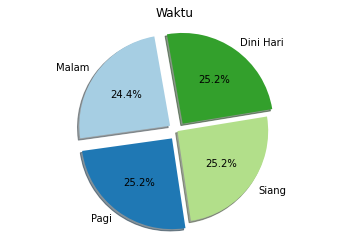

In [25]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['Malam', 'Pagi', 'Siang', 'Dini Hari']
explode = (0.1, 0.1, 0, 0.1)

#define Seaborn color palette to use
colors = sns.color_palette('Paired')[0:5]

# pie chart untuk 36 months term
fig1, ax1 = plt.subplots()
plt.title('Waktu')
ax1.pie(df.groupby('waktu').size(), explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=100, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.patch.set_facecolor('xkcd:white')
plt.show()

## Mengatasi Outliers

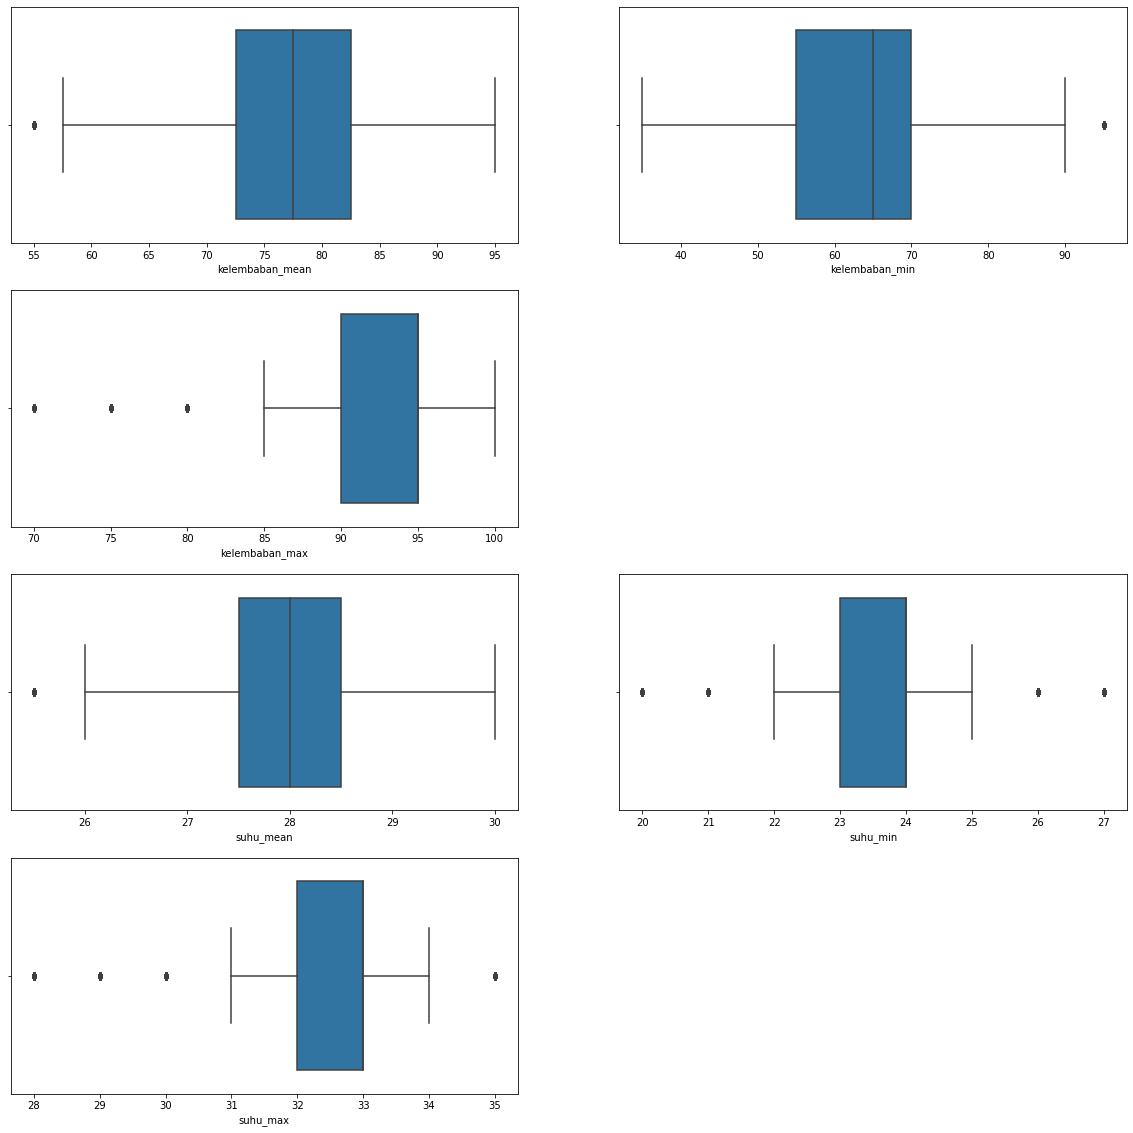

In [26]:
fig, axes = plt.subplots(4,2, figsize=(20,20))
sns.boxplot(x="kelembaban_mean", data=df, ax=axes[0, 0])
sns.boxplot(x="kelembaban_min", data=df, ax=axes[0, 1])
sns.boxplot(x="kelembaban_max", data=df, ax=axes[1, 0])
fig.delaxes(ax=axes[1,1])

sns.boxplot(x="suhu_mean", data=df, ax=axes[2, 0])
sns.boxplot(x="suhu_min", data=df, ax=axes[2, 1])
sns.boxplot(x="suhu_max", data=df, ax=axes[3, 0])
fig.delaxes(ax=axes[3,1])

In [27]:
old = df.shape

z = np.abs(stats.zscore(df[numeric]))
df = (df[(z<3).all(axis=1)])

new = df.shape
print("Jumlah data sebelum ZScore : ", old)
print("Jumlah data sesudah ZScore : ", new)

Jumlah data sebelum ZScore :  (14665, 13)
Jumlah data sesudah ZScore :  (14114, 13)


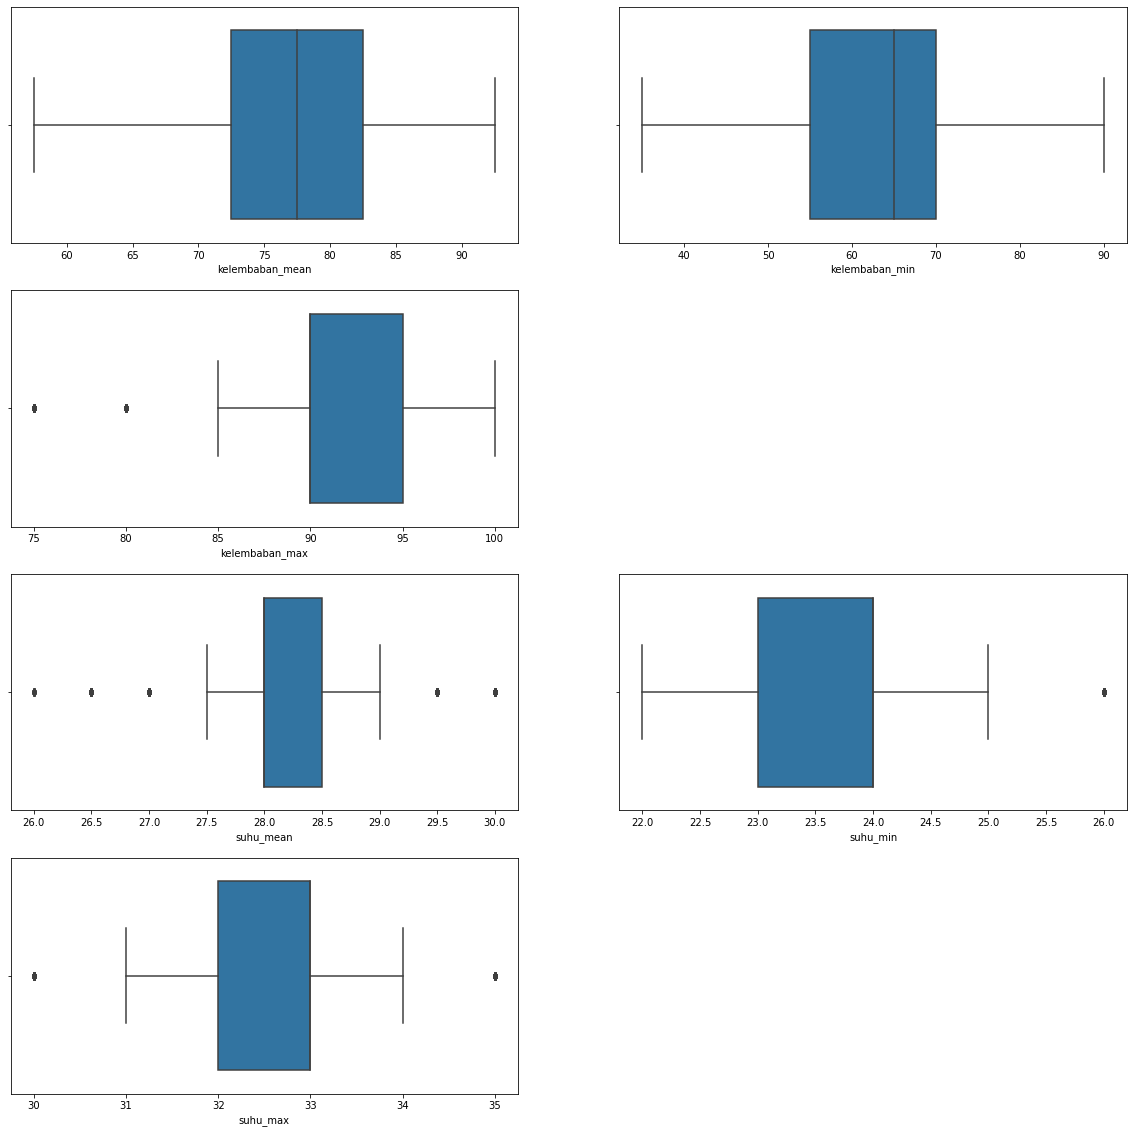

In [28]:
fig, axes = plt.subplots(4,2, figsize=(20,20))
sns.boxplot(x="kelembaban_mean", data=df, ax=axes[0, 0])
sns.boxplot(x="kelembaban_min", data=df, ax=axes[0, 1])
sns.boxplot(x="kelembaban_max", data=df, ax=axes[1, 0])
fig.delaxes(ax=axes[1,1])

sns.boxplot(x="suhu_mean", data=df, ax=axes[2, 0])
sns.boxplot(x="suhu_min", data=df, ax=axes[2, 1])
sns.boxplot(x="suhu_max", data=df, ax=axes[3, 0])
fig.delaxes(ax=axes[3,1])

# Modeling

### Copy Data Frame

In [29]:
df_model1 = df.copy()
df_model2 = df.copy()
df_model3 = df.copy()

df_model2.drop(["tanggal", "bulan", "tahun"], axis=1, inplace=True)
df_model3.drop(["kelembaban_min", "kelembaban_max", "suhu_min", "suhu_max"], axis=1, inplace=True)

## Model 1

### Membuat Column Transformer

In [30]:
categoric = ['wilayah', 'waktu', 'hari', 'tahun', 'bulan']
numeric = ['kelembaban_min', 'kelembaban_max', 'kelembaban_mean', 'suhu_min', 'suhu_max', 'suhu_mean']

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer

preprocessor1 = ColumnTransformer([
    ('numeric', StandardScaler(), numeric),
    ('categoric_ohc', OneHotEncoder(handle_unknown='ignore'), ['waktu', 'tahun']),
    ('categoric_lbl', OrdinalEncoder(), ['wilayah', 'hari', 'bulan', 'tahun']),
])

### Splitting Data

In [31]:
X1 = df_model1.drop(columns=["cuaca"])
y1 = df_model1["cuaca"]

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.05, random_state=42, stratify=y1)
X_train1.shape, X_test1.shape, y_train1.shape, y_test1.shape

((13408, 12), (706, 12), (13408,), (706,))

### Random Forest Classifier

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

pipeline_rf1 = Pipeline([
    ('prep', preprocessor1),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

model_rf1 = pipeline_rf1.fit(X_train1, y_train1)
print(model_rf1.score(X_train1, y_train1), model_rf1.score(X_test1, y_test1))

1.0 0.8356940509915014


### Extra Trees Classifier

In [35]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline

pipeline_xtra1 = Pipeline([
    ('prep', preprocessor1),
    ('algo', ExtraTreesClassifier(n_jobs=-1, random_state=42))
])

model_xtra1 = pipeline_xtra1.fit(X_train1, y_train1)
print(model_xtra1.score(X_train1, y_train1), model_xtra1.score(X_test1, y_test1))

1.0 0.830028328611898


## Model 2

### Membuat Column Transformer

In [36]:
categoric = ['wilayah', 'waktu']
numeric = ['kelembaban_min', 'kelembaban_max', 'kelembaban_mean', 'suhu_min', 'suhu_max', 'suhu_mean']

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

preprocessor2 = ColumnTransformer([
    ('numeric', StandardScaler(), numeric),
    ('categoric_ohc', OneHotEncoder(handle_unknown='ignore'), ['waktu']),
    ('categoric_lbl', OrdinalEncoder(), ['wilayah']),
])

### Splitting Data

In [37]:
X2 = df_model2.drop(columns=["cuaca"])
y2 = df_model2["cuaca"]

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.05, random_state=42, stratify=y2)
X_train2.shape, X_test2.shape, y_train2.shape, y_test2.shape

((13408, 9), (706, 9), (13408,), (706,))

### Random Forest Classifier

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

pipeline_rf2 = Pipeline([
    ('prep', preprocessor2),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

model_rf2 = pipeline_rf2.fit(X_train2, y_train2)
print(model_rf2.score(X_train2, y_train2), model_rf2.score(X_test2, y_test2))

0.752535799522673 0.5949008498583569


### Extra Trees Classifier

In [39]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline

pipeline_xtra2 = Pipeline([
    ('prep', preprocessor2),
    ('algo', ExtraTreesClassifier(n_jobs=-1, random_state=42))
])

model_xtra2 = pipeline_xtra2.fit(X_train2, y_train2)
print(model_xtra2.score(X_train2, y_train2), model_xtra2.score(X_test2, y_test2))

0.7526103818615751 0.5920679886685553


## Model 3

### Membuat Column Transformer

In [50]:
preprocessor3 = ColumnTransformer ([
    ('numeric', StandardScaler(), ['kelembaban_mean', 'suhu_mean']),
    ('categoric_ohc', OneHotEncoder(handle_unknown='ignore'), ['waktu']),
    ('categoric_lbl', OrdinalEncoder(), ['wilayah', 'hari', 'tahun', 'bulan']),
])

### Splitting Data

In [53]:
X3 = df_model3.drop(columns=["cuaca"])
y3 = df_model3["cuaca"]

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.05, random_state=42, stratify=y3)
X_train3.shape, X_test3.shape, y_train3.shape, y_test3.shape

((13408, 8), (706, 8), (13408,), (706,))

### Random Forest Classifier

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

pipeline_rf3 = Pipeline([
    ('prep', preprocessor3),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

model_rf3 = pipeline_rf3.fit(X_train3, y_train3)
print(model_rf3.score(X_train3, y_train3), model_rf3.score(X_test3, y_test3))

1.0 0.8427762039660056


### Extra Trees Classifier

In [55]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline

pipeline_xtra3 = Pipeline([
    ('prep', preprocessor3),
    ('algo', ExtraTreesClassifier(n_jobs=-1, random_state=42))
])

model_xtra3 = pipeline_xtra3.fit(X_train3, y_train3)
print(model_xtra3.score(X_train3, y_train3), model_xtra3.score(X_test3, y_test3))

1.0 0.8172804532577904


# Evaluasi

## Model 1

In [46]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model_rf1.predict(X_test1)
y_pred_train = model_rf1.predict(X_train1)

print("Random Forest Model 1")
print(confusion_matrix(y_test1, y_pred), "\n")
print(classification_report(y_train1, y_pred_train), "\n")
print(classification_report(y_test1, y_pred), "\n")

y_pred = model_xtra1.predict(X_test1)
y_pred_train = model_xtra1.predict(X_train1)

print("Extra Trees Model 1")
print(confusion_matrix(y_test1, y_pred), "\n")
print(classification_report(y_train1, y_pred_train), "\n")
print(classification_report(y_test1, y_pred))


Random Forest Model 1
[[194  24  24]
 [ 22 249  11]
 [ 29   6 147]] 

              precision    recall  f1-score   support

     Berawan       1.00      1.00      1.00      4587
       Cerah       1.00      1.00      1.00      5363
       Hujan       1.00      1.00      1.00      3458

    accuracy                           1.00     13408
   macro avg       1.00      1.00      1.00     13408
weighted avg       1.00      1.00      1.00     13408
 

              precision    recall  f1-score   support

     Berawan       0.79      0.80      0.80       242
       Cerah       0.89      0.88      0.89       282
       Hujan       0.81      0.81      0.81       182

    accuracy                           0.84       706
   macro avg       0.83      0.83      0.83       706
weighted avg       0.84      0.84      0.84       706
 

Extra Trees Model 1
[[194  24  24]
 [ 25 246  11]
 [ 30   6 146]] 

              precision    recall  f1-score   support

     Berawan       1.00      1.00      1.

## Model 2

In [45]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model_rf2.predict(X_test2)
y_pred_train = model_rf2.predict(X_train2)

print("Random Forest Model 2")
print(confusion_matrix(y_test2, y_pred), "\n")
print(classification_report(y_train2, y_pred_train), "\n")
print(classification_report(y_test2, y_pred), "\n")

y_pred = model_xtra2.predict(X_test2)
y_pred_train = model_xtra2.predict(X_train2)

print("Extra Trees Model 2")
print(confusion_matrix(y_test2, y_pred), "\n")
print(classification_report(y_train2, y_pred_train), "\n")
print(classification_report(y_test2, y_pred))


Random Forest Model 2
[[132  62  48]
 [ 63 187  32]
 [ 50  31 101]] 

              precision    recall  f1-score   support

     Berawan       0.73      0.71      0.72      4587
       Cerah       0.79      0.80      0.79      5363
       Hujan       0.73      0.74      0.73      3458

    accuracy                           0.75     13408
   macro avg       0.75      0.75      0.75     13408
weighted avg       0.75      0.75      0.75     13408
 

              precision    recall  f1-score   support

     Berawan       0.54      0.55      0.54       242
       Cerah       0.67      0.66      0.67       282
       Hujan       0.56      0.55      0.56       182

    accuracy                           0.59       706
   macro avg       0.59      0.59      0.59       706
weighted avg       0.60      0.59      0.60       706
 

Extra Trees Model 2
[[150  57  35]
 [ 77 179  26]
 [ 65  28  89]] 

              precision    recall  f1-score   support

     Berawan       0.68      0.80      0.

## Model 3

In [56]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model_rf3.predict(X_test3)
y_pred_train = model_rf3.predict(X_train3)

print("Random Forest Model 3")
print(confusion_matrix(y_test3, y_pred), "\n")
print(classification_report(y_train3, y_pred_train), "\n")
print(classification_report(y_test3, y_pred), "\n")

y_pred = model_xtra3.predict(X_test3)
y_pred_train = model_xtra3.predict(X_train3)

print("Extra Trees Model 3")
print(confusion_matrix(y_test3, y_pred), "\n")
print(classification_report(y_train3, y_pred_train), "\n")
print(classification_report(y_test3, y_pred))


Random Forest Model 3
[[196  24  22]
 [ 23 251   8]
 [ 28   6 148]] 

              precision    recall  f1-score   support

     Berawan       1.00      1.00      1.00      4587
       Cerah       1.00      1.00      1.00      5363
       Hujan       1.00      1.00      1.00      3458

    accuracy                           1.00     13408
   macro avg       1.00      1.00      1.00     13408
weighted avg       1.00      1.00      1.00     13408
 

              precision    recall  f1-score   support

     Berawan       0.79      0.81      0.80       242
       Cerah       0.89      0.89      0.89       282
       Hujan       0.83      0.81      0.82       182

    accuracy                           0.84       706
   macro avg       0.84      0.84      0.84       706
weighted avg       0.84      0.84      0.84       706
 

Extra Trees Model 3
[[191  28  23]
 [ 31 244   7]
 [ 34   6 142]] 

              precision    recall  f1-score   support

     Berawan       1.00      1.00      1.